## Dissipative Atom-Cavity system

### setup of a simple atom cavity model

- define operators for the system Hamiltonian - JC Hamiltonian - assuming resonance
- define Master equation which descibes the time evolution
- leaky cavity (no loss directly from the atom into the environment)

In [206]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt


In [207]:
N = 10  # num. cavity modes
w0 = 1.0 * 2 * np.pi
g = 0.1 * 2 * np.pi # weak couling 
kappa = 0.05
gamma = 0.05
beta = 0.05


# operators
a = qt.tensor(qt.destroy(N), qt.identity(2)) #a.dag()
sm = qt.tensor(qt.identity(N), qt.destroy(2))
c_ops = [np.sqrt(kappa) * a] #collapse operators
e_ops = [a.dag() * a, sm.dag() * sm, sm.dag() + sm, -1j*(sm.dag() - sm)] #expectation values

#Hamiltonian
H = w0*a.dag()*a + w0*sm.dag()*sm + g*(a.dag() + a)*(sm + sm.dag())

#initial state
psi0 = qt.ket2dm(qt.tensor(qt.basis(N,1), qt.basis(2,0)))


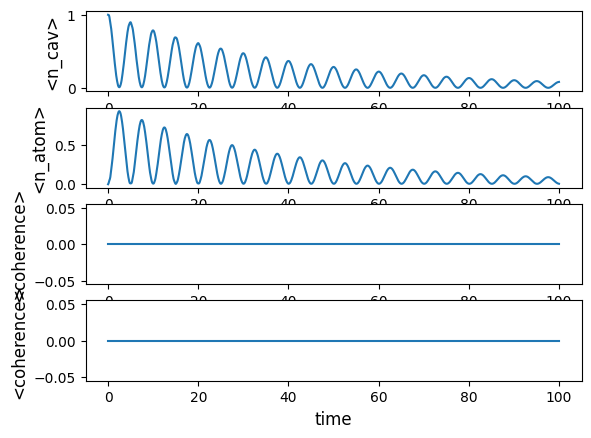

In [208]:
#solving the dynamics using mesolve()
times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result = qt.mesolve(H, psi0, times, c_ops, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "<coherence>", "<coherence>"]
)


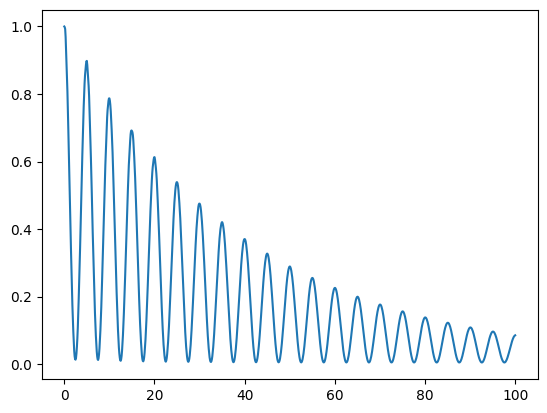

In [209]:
#using matplotlib to plot the same

#expectation values of cavity:
y_cav = result.expect[0]
y_atom = result.expect[1]
x = result.times

plt.plot(x, y_cav)

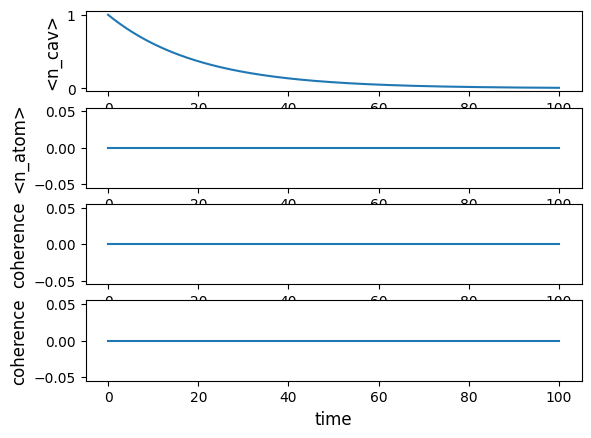

In [210]:
#try without coupling 
H_0 = w0*a.dag()*a + w0*sm.dag()*sm 


times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result = qt.mesolve(H_0, psi0, times, c_ops, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "coherence", "coherence"]
)


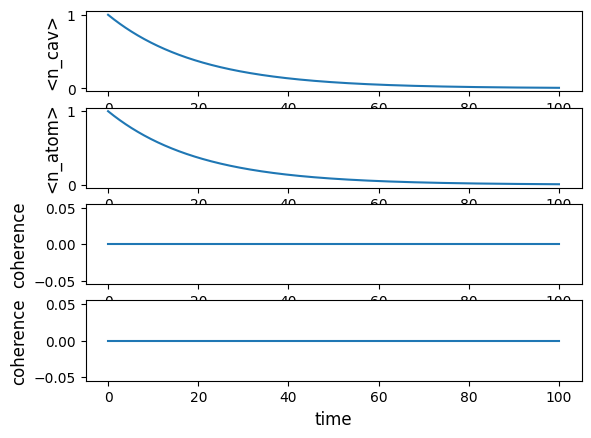

In [211]:
#start with ket(1,1) and add atomic decay
c_ops_dec = [np.sqrt(kappa) * a, np.sqrt(gamma) * sm]

psi11 = qt.ket2dm(qt.tensor(qt.basis(N,1), qt.basis(2,1)))
H_0 = w0*a.dag()*a + w0*sm.dag()*sm 



times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result = qt.mesolve(H_0, psi11, times, c_ops_dec, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "coherence", "coherence"]
)


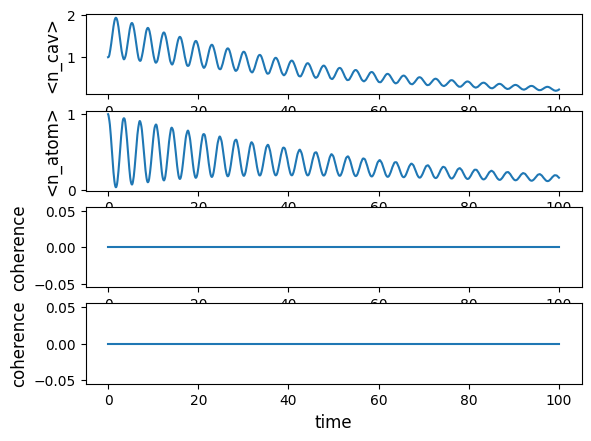

In [212]:
#only decay, no leaking cavity and coupling

c_ops_dec_only = [np.sqrt(gamma) * sm]

psi11 = qt.ket2dm(qt.tensor(qt.basis(N,1), qt.basis(2,1)))


times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result = qt.mesolve(H, psi11, times, c_ops_dec_only, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "coherence", "coherence"]
)

### ideas
- interactive parameters
- animate over time and changeable parameters and initial values
- add dephasing
- add spin echo 

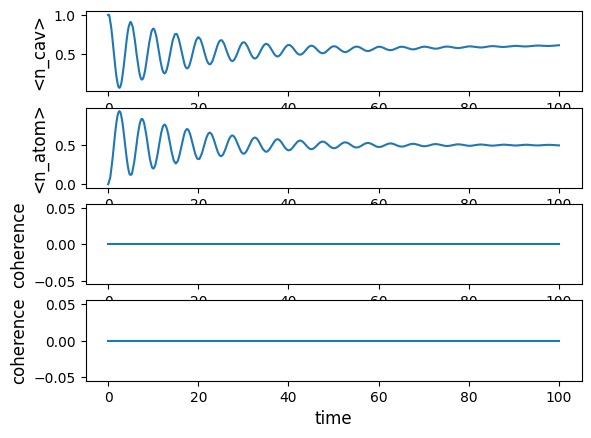

In [213]:
# add dephasing
#operator
sz = sm.dag() * sm - sm * sm.dag()

c_ops_deph = [np.sqrt(beta) * sz]

times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result = qt.mesolve(H, psi0, times, c_ops_deph, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "coherence", "coherence"]
)


### Spin Echo

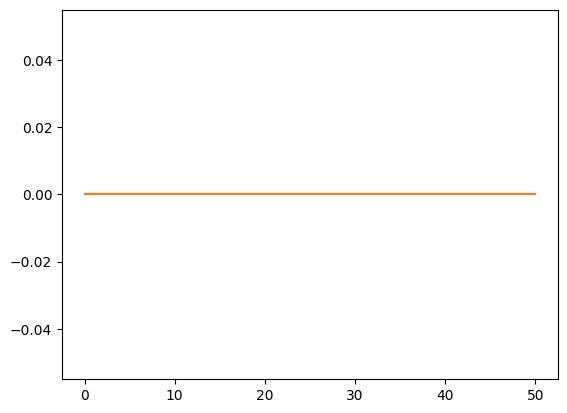

In [214]:
# dephasing until time times1

times1 = np.linspace(0, 0.5*np.pi / g, 500)
result1 = qt.mesolve(H, psi0, times1, c_ops_deph, e_ops, options={'store_states': True}) #important to turn on that states are being safed

# apply echo
#make a function or slider later
U_pi = (-1j * np.pi/2 * (sm.dag()+sm)).expm()

#psi1 = U_pi * result1.states[-1]
psi1 = result1.states[-1]

# rest of time evolution
times2 =np.linspace(0.5*np.pi / g, 5 * 2 * np.pi / g, 500)
result2 = qt.mesolve(H, psi1, times2, c_ops_deph, e_ops)

#visualize
times = np.concatenate([result1.times, result2.times])
result = [np.concatenate([result1.expect[i], result2.expect[i]]) for i in range(len(e_ops))]

plt.plot(times,result[2])
plt.plot(times,result[3])



### Look at a state with coherence

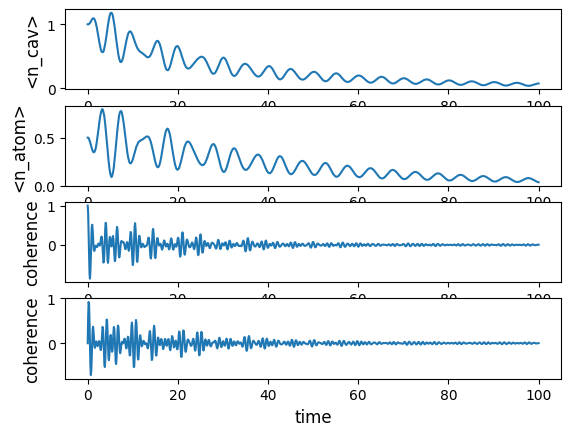

In [215]:
# atomic basis
S_g = qt.basis(2, 0)
S_e = qt.basis(2, 1)

# |+x> = (|g> + |e>)/sqrt(2)  -> <σx>=1, <σy>=0, <σz>=0
plus_x = (S_g + S_e).unit()

#initial state
psi_plus = qt.ket2dm(qt.tensor(qt.basis(N,1), plus_x))

#solving the dynamics using mesolve()
times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result =qt.mesolve(H, psi_plus, times, c_ops, e_ops)

fig, axes = qt.plot_expectation_values(
    [result], ylabels=["<n_cav>", "<n_atom>", "coherence", "coherence"]
)



In [216]:

# Example: create a random pure state and convert to density matrix
psi = psi_plus          # Random ket |ψ⟩ in dimension 4
rho = psi * psi.dag()         # Density matrix ρ = |ψ⟩⟨ψ|
rho_atom = qt.ptrace(rho,1)

# Convert the Qobj to a NumPy array
rho_array = rho_atom.full()
print(rho_array[0,1])


print("Full density matrix:\n", rho_array)

(0.4999999999999998+0j)
Full density matrix:
 [[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


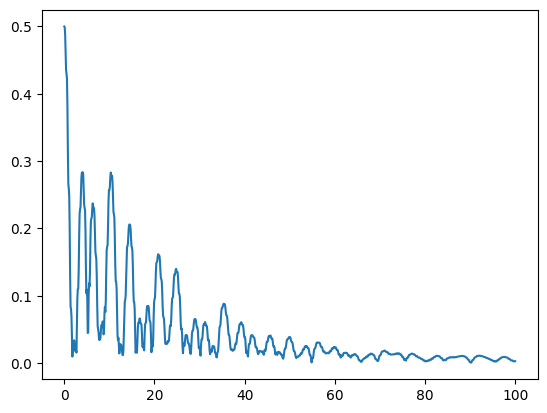

In [217]:
coh_ge = qt.tensor(qt.qeye(N), S_g * S_e.dag())  # |g><e|
coh_eg = coh_ge.dag()                            # |e><g|

e_ops_dec = [a.dag()*a, sm.dag()*sm, coh_ge, coh_eg]


# atomic basis
S_g = qt.basis(2, 0)
S_e = qt.basis(2, 1)

# |+x> = (|g> + |e>)/sqrt(2)  -> <σx>=1, <σy>=0, <σz>=0
plus_x = (S_g + S_e).unit()

#initial state
psi_plus = qt.ket2dm(qt.tensor(qt.basis(N,1), plus_x))

#solving the dynamics using mesolve()
times = np.linspace(0, 10 * 2 * np.pi / g, 1000)
result =qt.mesolve(H, psi_plus, times, c_ops, e_ops_dec)

plt.plot(times, abs(result.expect[2]))

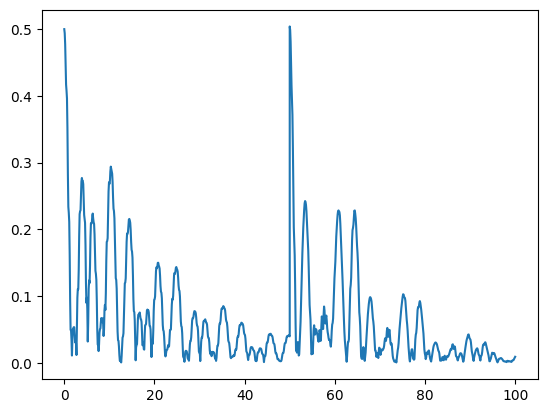

In [232]:
# dephasing until time times1

times1 = np.linspace(0, 10*np.pi / g, 500)
result1 = qt.mesolve(H, psi_plus, times1, c_ops_deph, e_ops_dec, options={'store_states': True}) #important to turn on that states are being saved

# apply echo
#make a function or slider later
U_pi = (-1j * np.pi/2 * (sm.dag()+sm)).expm()

psi1 = U_pi * result1.states[-1]
#psi1 = result1.states[-1]

# rest of time evolution
times2 =np.linspace(10*np.pi / g, 20 * np.pi / g, 500)
result2 = qt.mesolve(H, psi1, times2, c_ops_deph, e_ops_dec)

#visualize
times = np.concatenate([result1.times, result2.times])
result = [np.concatenate([result1.expect[i], result2.expect[i]]) for i in range(len(e_ops))]

plt.plot(times,abs(result[2]))

c:\Users\SophiaCarmenSimon\dissipativeAtomCavity\.venv\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


[[0.11908194-4.32317969e-18j 0.02041219+8.55529104e-04j]
 [0.02041219-8.55529104e-04j 0.11670029+3.47293933e-18j]]
[[0.11670029+0.j         0.02041219-0.00085553j]
 [0.02041219+0.00085553j 0.11908194+0.j        ]]


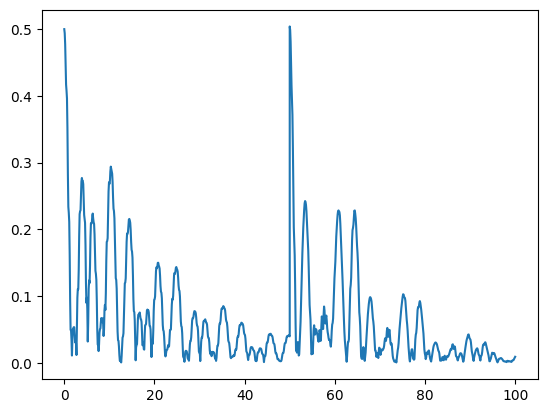

In [245]:
# π-pulse operator on atom: rotation around X
X_pi = qt.tensor(qt.qeye(N), qt.sigmax())  # Cavity identity ⊗ σx

# Split time into two parts
times1 = np.linspace(0, 10*np.pi / g, 500)
times2 =np.linspace(10*np.pi / g, 20 * np.pi / g, 500)

# First evolution
result1 = qt.mesolve(H, psi_plus, times1, c_ops_deph, e_ops_dec, options={'store_states': True})



# State at t_pi
rho_mid = result1.states[-1]

# Example: create a random pure state and convert to density matrix
psi =rho_mid          # Random ket |ψ⟩ in dimension 4
rho = psi * psi.dag()         # Density matrix ρ = |ψ⟩⟨ψ|
rho_atom = qt.ptrace(rho,1)

# Convert the Qobj to a NumPy array
rho_array = rho_atom.full()
print(rho_array)

# Apply π pulse
rho_mid_pulsed = X_pi * psi #rho_mid * X_pi.dag()

# Example: create a random pure state and convert to density matrix
psi = rho_mid_pulsed          # Random ket |ψ⟩ in dimension 4
rho = psi * psi.dag()         # Density matrix ρ = |ψ⟩⟨ψ|
rho_atom = qt.ptrace(rho,1)

# Convert the Qobj to a NumPy array
rho_array = rho_atom.full()
print(rho_array)

# Second evolution
result2 = qt.mesolve(H, rho_mid_pulsed, times2, c_ops_deph, e_ops_dec)

# Combine results
times_full = np.concatenate([times1, times2])
result_full = [np.concatenate([result1.expect[i], result2.expect[i]]) for i in range(len(e_ops_dec))]

plt.plot(times_full,abs(result_full[2]))

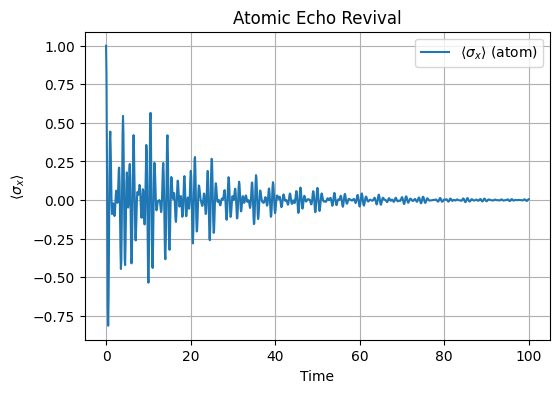

In [241]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Atomic basis
S_g = qt.basis(2, 0)
S_e = qt.basis(2, 1)

# π-pulse operator on atom (rotation around X)
X_pi = qt.tensor(qt.qeye(N), qt.sigmax())  # Cavity identity ⊗ σx

# Define σx expectation operator for the atom
sigma_x = qt.tensor(qt.qeye(N), S_g*S_e.dag() + S_e*S_g.dag())

# Expectation operators
e_ops_echo = [a.dag()*a, sm.dag()*sm, sigma_x]  # cavity, atom population, σx

# Split time
t_pi = 10 * np.pi / g
times1 = np.linspace(0, t_pi, 500)
times2 = np.linspace(t_pi, 2*t_pi, 500)

# First evolution with dephasing
result1 = qt.mesolve(H, psi_plus, times1, c_ops_deph, e_ops_echo, options={'store_states': True})

# Apply π-pulse at t_pi
rho_mid = result1.states[-1]
rho_mid_pulsed = X_pi * rho_mid * X_pi.dag()

# Second evolution
result2 = qt.mesolve(H, rho_mid_pulsed, times2, c_ops_deph, e_ops_echo)

# Combine times and expectation values
times_full = np.concatenate([result1.times, result2.times])
result_full = [np.concatenate([result1.expect[i], result2.expect[i]]) for i in range(len(e_ops_echo))]

# Plot σx to see the echo revival
plt.figure(figsize=(6,4))
plt.plot(times_full, result_full[2], label=r'$\langle \sigma_x \rangle$ (atom)')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma_x \rangle$')
plt.title('Atomic Echo Revival')
plt.grid(True)
plt.legend()
plt.show()


warum funktioniert zweite implementation von echo nicht +
genau ueberlegen was mit state passiert und ob richtig ist